# Quick scripting for XPS-tool

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Embedded imports
import os, sys
import math
import matplotlib.pyplot as plt

In [13]:
# Third party imports
import numpy as np
import pandas as pd
import scipy as sp

In [4]:
# Temporary solution for local imports
sys.path.append('..')
from xpstool import scientahandler as scih
from xpstool import specshandler as speh
from xpstool.region import Region
from xpstool import background as bg
from xpstool import fitter

In [5]:
# Constants
al_k_alpha = 1486.61 # Al K-alpha photon source energy
p22_energy_3800 = 3800 # Photon energy from the p22 beamline
p22_energy_4600 = 4600 # Photon energy from the p22 beamline

## Nanolab data (Al K-alpha radiation 1486.61 eV)

## Petra III, P22 beamline (Scienta analyzer)

In [6]:
# ---SCIENTA DATA---
# Full path to data files
data_path = "/Users/Shipilin/Documents/07_DataAnalysis/2018-RhFe_alloys/2018-November_Rh80Fe20/2018-11_Beamtime/"
# Folders to add to the full path above 
data_folders = [
    "Data"
]
# Output folders
output_folders = [
    "ProcessedData"
]

In [7]:
# List of all directories (combine the full path with specified folders)
all_dirs = ["".join([data_path, data_folder]) for data_folder in data_folders]
all_output_dirs = ["".join([data_path, output_folder]) for output_folder in output_folders]

# Iterating through directories displaying existing files
all_files = []
for i, dirname in enumerate(sorted(all_dirs)):
    if i > 0: # Just to make it prettier (no empty line before the first output)
        print() # Otherwise, add an empty line to separate outputs
    print(f"all_dirs[{i}]: {dirname}")
    
    # Iterating through the list of files inside the directory. Files are sorted
    # according to the last _number value in their name using lambda function
    files = []
    file_idx = 0
    for file in sorted(os.listdir(all_dirs[i])):
        if file.endswith(".txt"):                         
            files.append(file)
            print(f"---> all_files[{i}][{file_idx}]: {file}")
            file_idx += 1
    all_files.append(files)

all_dirs[0]: /Users/Shipilin/Documents/07_DataAnalysis/2018-RhFe_alloys/2018-November_Rh80Fe20/2018-11_Beamtime/Data
---> all_files[0][0]: 0000.txt
---> all_files[0][1]: 0001.txt
---> all_files[0][2]: 0002.txt
---> all_files[0][3]: 0003.txt
---> all_files[0][4]: 0004.txt
---> all_files[0][5]: 0005.txt
---> all_files[0][6]: 0006.txt
---> all_files[0][7]: 0007.txt
---> all_files[0][8]: 0008.txt
---> all_files[0][9]: 0009.txt
---> all_files[0][10]: 0010.txt
---> all_files[0][11]: 0011.txt
---> all_files[0][12]: 0012.txt
---> all_files[0][13]: 0013.txt
---> all_files[0][14]: 0014.txt
---> all_files[0][15]: 0015.txt
---> all_files[0][16]: 0016.txt
---> all_files[0][17]: 0017.txt
---> all_files[0][18]: 0018.txt
---> all_files[0][19]: 0019.txt
---> all_files[0][20]: 0020.txt
---> all_files[0][21]: 0021.txt
---> all_files[0][22]: 0022.txt
---> all_files[0][23]: 0023.txt
---> all_files[0][24]: 0024.txt
---> all_files[0][25]: 0025.txt
---> all_files[0][26]: 0026.txt
---> all_files[0][27]: 0027.t


Region Name: Ef_4600
Lens Mode: T_HiPPHAXPES
Pass Energy: 100
Number of Sweeps: 3
Excitation Energy: 4600
Energy Scale: Binding
Acquisition Mode: Swept
Energy Unit: Binding
Center Energy: 4.0
Low Energy: 6.0
High Energy: 2.0
Energy Step: 0.1
Step Time: 471
Detector First X-Channel: 1
Detector Last X-Channel: 512
Detector First Y-Channel: 1
Detector Last Y-Channel: 460
Number of Slices: 1
File: D:\Data\2018_11_RhFebeamtime\0125.pxt,.ibw,.txt
Sequence: D:\SES_1.7.2_Win64_Package\SES_1.7.2_Win64\Sequences\factory.seq
Spectrum Name: Ef_4600
Instrument: HiPP-2 10kV-9862
Location: 
User: 
Sample: 
Comments: Testing the voltage output;
Date: 2018-11-19
Time: 11:15:44
Time per Spectrum Channel: 121.518
DetectorMode: ADC


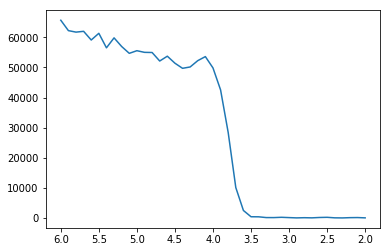

In [8]:
# Plot preview of a Scienta.txt file
scans = scih.importScientaFile("/".join([all_dirs[0], all_files[0][125]]))
output_dir = all_output_dirs[0]

#%matplotlib qt # Plotting in a separate interactive window
if len(scans) == 1:
    scans[0].invertEnergyScale(p22_energy_4600)
    print(scans[0])
    plt.plot(scans[0].getData()["energy"], scans[0].getData()["counts"])
    plt.gca().invert_xaxis()
else:
    fig, axs = plt.subplots(int(math.ceil(len(scans)/2)),2)
    for i, scan in enumerate(scans):
        axs[i].plot(scan.getData()["energy"], scan.getData()["counts"])
        axs[i].invert_xaxis()

## Shirley background

## Saving regions

## Fitting Fermi levels

[ 1.49285920e+04  3.79488664e+01 -4.46310209e+00  1.58933836e+04]


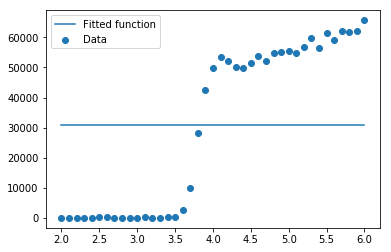

In [20]:
region.setFermiFlag()
fit_results = fitter.fitFermiEdge(region)
print(fit_results[0])
x = region.getData()['energy'].values.tolist()
y = region.getData()['counts'].values.tolist()
plt.figure
plt.scatter(x, y, label='Data')
plt.plot(x, fitter.errorFunc(x, 
                             fit_results[0][0], 
                             fit_results[0][1],
                             fit_results[0][2],
                             fit_results[0][3]),
                             label='Fitted function')
plt.legend(loc='best')
plt.show()